# Result for **FullConnect+MNIST**
### This notebook is for seed $42$. The results in the paper are the average of $5$ times with seeds in $[1, 19, 31, 42, 80]$

## Libraries

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torch.nn.utils import clip_grad_norm_
from opacus import PrivacyEngine
# from tensorflow.keras.layers import GaussianNoise

import os
import random
import numpy as np
import pandas as pd
import copy
import time
import sys
# import skimage



import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator


import ssl
ssl._create_default_https_context = ssl._create_unverified_context

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/image.so
  Expected in: /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/lib/libc10.dylib
  warn(f"Failed to load image Python extension: {e}")


## Models

In [2]:
# MNIST Fully Connected Net ----------------------------------------------------
# class MNISTNet(nn.Module):
#     def __init__(self):
#         super(MNISTNet, self).__init__()
#         self.fc1 = nn.Linear(28 * 28, 512)
#         self.fc2 = nn.Linear(512, 10)

#     def forward(self, x):
#         # flatten image input
#         x = x.view(-1, 28 * 28)
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x


# class MNISTNet_copy(nn.Module):
#     def __init__(self):
#         super(MNISTNet_copy, self).__init__()
#         self.fc1 = nn.Linear(28 * 28, 512)
#         self.fc2 = nn.Linear(512, 10)

#     def forward(self, x):
#         # flatten image input
#         x = x.view(-1, 28 * 28)
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 6, 
                           kernel_size = 4, stride = 1, padding = 0) #C1
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, 
                           kernel_size = 4, stride = 1, padding = 0) #C3
        self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 120, 
                           kernel_size = 4, stride = 1, padding = 0) #C5
        self.linear1 = nn.Linear(120, 84) # F6
        self.linear2 = nn.Linear(84, 10) # output
        self.tanh = nn.Tanh()
        self.avgpool = nn.AvgPool2d(kernel_size = 2, stride = 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.tanh(x)
        x = self.avgpool(x) #S2
        x = self.conv2(x)
        x = self.tanh(x)
        x = self.avgpool(x) #S4
        x = self.conv3(x)
        x = self.tanh(x)
    
        x = x.reshape(x.shape[0], -1) 
        x = self.linear1(x)
        x = self.tanh(x)
        x = self.linear2(x)
        return x

# class LeNet_copy(nn.Module):
#     def __init__(self):
#         super(LeNet_copy, self).__init__()

#         self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 6, 
#                            kernel_size = 5, stride = 1, padding = 0) #C1
#         self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, 
#                            kernel_size = 5, stride = 1, padding = 0) #C3
#         self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 120, 
#                            kernel_size = 5, stride = 1, padding = 0) #C5
#         self.linear1 = nn.Linear(120, 84) # F6
#         self.linear2 = nn.Linear(84, 10) # output
#         self.tanh = nn.Tanh()
#         self.avgpool = nn.AvgPool2d(kernel_size = 2, stride = 2)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.tanh(x)
#         x = self.avgpool(x) #S2
#         x = self.conv2(x)
#         x = self.tanh(x)
#         x = self.avgpool(x) #S4
#         x = self.conv3(x)
#         x = self.tanh(x)
    
#         x = x.reshape(x.shape[0], -1) 
#         x = self.linear1(x)
#         x = self.tanh(x)
#         x = self.linear2(x)
#         return x

## Prepare data

In [3]:
def create_loaders(dataset_name, n_workers, batch_size):
    train_data, test_data = load_data(dataset_name)
    train_loader_workers = dict()
    n = len(train_data)
    
    # preparing iterators for workers
    indices = np.arange(n)
    np.random.shuffle(indices)
    a = np.int64(np.floor(n / n_workers))
    top_ind = a * n_workers
    seq = range(a, top_ind, a)
    split = np.split(indices[:top_ind], seq)
    b = 0
    for ind in split:
        train_loader_workers[b] = DataLoader(Subset(train_data, ind), batch_size=batch_size, shuffle=True)
        b = b + 1
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    return train_loader_workers, test_loader


def load_data(dataset_name):
    if dataset_name == 'mnist':
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
        train_data = datasets.MNIST(root='./data', train=True,
                                    download=True, transform=transform)
        test_data = datasets.MNIST(root='./data', train=False,
                                   download=True, transform=transform)
    elif dataset_name == 'fashionmnist':
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
        train_data = datasets.FashionMNIST(root='./data', train=True,
                                    download=True, transform=transform)
        test_data = datasets.FashionMNIST(root='./data', train=False,
                                   download=True, transform=transform)


    elif dataset_name == 'cifar10':
        transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])
        transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])
        train_data = datasets.CIFAR10(root='./data', train=True,
                                      download=True, transform=transform_train)
        test_data = datasets.CIFAR10(root='./data', train=False,
                                     download=True, transform=transform_test)

    elif dataset_name == 'cifar100':
        transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5070751592371323, 0.48654887331495095, 0.4409178433670343],
                                 std=[0.5070751592371323, 0.48654887331495095, 0.4409178433670343])
        ])
        transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5070751592371323, 0.48654887331495095, 0.4409178433670343],
                                 std=[0.5070751592371323, 0.48654887331495095, 0.4409178433670343])
        ])
        train_data = datasets.CIFAR100(root='./data', train=True,
                                       download=True, transform=transform_train)
        test_data = datasets.CIFAR100(root='./data', train=False,
                                      download=True, transform=transform_test)

    else:
        raise ValueError(dataset_name + ' is not known.')

    return train_data, test_data

## Parameter and Setup

In [8]:
# Hyperparameters
RANDOM_SEED = 42
lr = 0.1
BATCH_SIZE = 30
NUM_EPOCHS = 10
NUM_WORKERS = 4
mean =0
var= 0.00001
D = 10  # compute thread
h = 0.01  # sparse level 99%
h1= 0.005 # gsparse level


# mean = 0
# var = 0.05
#var表示全局敏感度*delta，全局敏感=1，delta=1.4，c=1
# RGB
# noise = sigma * np.random.randn(256, 256, 3)#高斯噪声



if not os.path.exists('result'):
    os.mkdir('result')
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", DEVICE)

Using device:  cpu


## Functions

In [9]:
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
    
def evaluate_accuracy(model, data_iter, device):
    acc_sum, num_epo = 0.0, 0
    for image, label in data_iter:
        image, label = image.to(device), label.to(device)
        acc_sum += (model(image).argmax(dim=1) == label).float().sum().item()
        num_epo += label.shape[0]
    return acc_sum / num_epo * 100


# 定义Top_k sparse
def prep_grad(x):
    x_flat = torch.unsqueeze(x, 0).flatten()
    dim = x.shape#dim代表维度，相当于有多少个数
    d = x_flat.shape[0]
    return x_flat, dim, d


def top_k_opt(x, h):
    """
    :param x: vector to sparsify
    :param h: density
    :return: compressed vector
    """
    x, dim, d = prep_grad(x)
    # number of coordinates kept保留的坐标数，保留top多少 r就是这个k的数量
    r = int(np.maximum(1, np.floor(d * h)))
    # positions of top_k coordinates topk的坐标位置，保留了值和索引
    _, ind = torch.topk(torch.abs(x), r)
    mask = torch.zeros_like(x)#生成与x相同的全0张量
    mask[ind] = 1#把索引那一行全置为1
    t = mask * x
    #上面是top-k
    t = t.reshape(dim)
    
    return t


def compt(old, new):
    result = 0
    for i in range(len(old)):
        result += ((old[i].view(-1) - new[i].view(-1)) ** 2).sum().item()
    return result

# GTOP-K-SASG

In [10]:
print("GSASG  lr:"+str(lr)+"--h:"+str(h)+"--epoch:"+str(NUM_EPOCHS)+"--worker:"+str(NUM_WORKERS))
seed_torch(RANDOM_SEED)
model = MNISTNet()
model.to(DEVICE)
model_copy = MNISTNet_copy()
model_copy.to(DEVICE)
loss = nn.CrossEntropyLoss()  # 计算损失函数

# prepare data
dataset_name = 'fashionmnist'
train_loader_workers, test_loader = create_loaders(dataset_name, NUM_WORKERS, BATCH_SIZE)

NUM_PARAS = sum([1 for param in model.parameters()])
print("Number_parameter:", NUM_PARAS)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Element_parameter:", total_params)
total_params_sparse = 0
total_params_sparse_gtop = 0
for p in model.parameters():
    x, dim, d = prep_grad(p)#
    r = int(np.maximum(1, np.floor(d * h)))#h是代表稀疏化程度百分之99，floor向下取整
    total_params_sparse += r
print("Element_parameter_sparse:", total_params_sparse)#稀疏化之后参与计算的参数也就是参数数量

for p in model.parameters():
    u = top_k_opt(p, h)
    x1, dim1, d1 = prep_grad(u)#
    s = int(np.maximum(1, np.floor(d1 * h)))#h是代表稀疏化程度百分之99，floor向下取整
    total_params_sparse_gtop += s
print("Element_parameter_sparse_gtop:", total_params_sparse_gtop)

state_dict = [0 for col in range(NUM_WORKERS)]
grad_worker = [[0 for col in range(NUM_PARAS)] for row in range(NUM_WORKERS)]#col是列，row是行
grad_gtworker = [[0 for col in range(NUM_PARAS)] for row in range(NUM_WORKERS)]#col是列，row是行  新加的！！！！
error_worker = [[0 for col in range(NUM_PARAS)] for row in range(NUM_WORKERS)]
error_gtworker = [[0 for col in range(NUM_PARAS)] for row in range(NUM_WORKERS)]# 新加的！！！！
grad_old = [0 for col in range(NUM_PARAS)]
grad_new = [0 for col in range(NUM_PARAS)]
para_store = [0 for col in range(NUM_PARAS)]
tau = [0 for col in range(NUM_WORKERS)]
para_list = []
Skip_epoch = []#跳过的轮次
Loss_epoch = []#损失的轮次
train_Acc_epoch = []
test_Acc_epoch = []
Skip_iter = []
Loss_iter = []
train_acc_iter = []
test_acc_iter = []
Round_epoch = []
iter_num = 0
skip_iter = 0
flag_acc = False
L=0
H=0
for epoch in range(NUM_EPOCHS):
   
    train_l_sum, train_acc_sum, num = 0.0, 0.0, 0
    train_loader_iter = [iter(train_loader_workers[w]) for w in range(NUM_WORKERS)]
    iter_steps = len(train_loader_workers[0])
    skip_num = [[0 for col in range(iter_steps)] for row in range(NUM_EPOCHS)]
    for batch_idx in range(iter_steps):
        model.train()
        model_copy.train()
        grad_agg = [0 for col in range(NUM_PARAS)]
        grad_gtagg = [0 for col in range(NUM_PARAS)]#新加的！！！！！
        skip_idx = 0
        if (epoch * iter_steps + batch_idx) < D:
      
            for w_id in range(NUM_WORKERS):
#                 print(NUM_WORKERS)
                images, labels = next(train_loader_iter[w_id])
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                y_hat = model(images)
                Loss = loss(y_hat, labels)
                Loss.backward()
                

                with torch.no_grad():
                    p_id = 0
                    for p in model.parameters():#每个work的本地训练循环
#                         size_in_bytes = sys.getsizeof(model.parameters())#计算一个参数的bit
#                         size_in_bits = size_in_bytes * 8
#                         print(size_in_bits)
                        g = lr * p.grad.data.clone().detach() + error_gtworker[w_id][p_id]
                        Tk_sparse = top_k_opt(g, h)#本地top-k稀疏化
                        Tk_sparse_clip = clip_grad_norm_(Tk_sparse, max_norm=1.0, norm_type=2) #梯度修剪
                        noise = np.random.normal(mean, var**2, Tk_sparse_clip.shape)#计算噪声大小
                        Tk_sparse_clip_noise = Tk_sparse_clip + noise
#                         Tk_sparse_noise_clip = clip_grad_norm_(Tk_sparse_clip_noise, max_norm=20, norm_type=2)
                        grad_agg[p_id] += Tk_sparse_clip_noise
                        error_worker[w_id][p_id] = g - Tk_sparse_clip_noise
                        grad_worker[w_id][p_id] = Tk_sparse_clip_noise
                        GTk_sparse = top_k_opt(grad_worker[w_id][p_id], h1)#111111
                        grad_gtagg[p_id] += GTk_sparse#11111111
                        error_gtworker[w_id][p_id] = error_worker[w_id][p_id] + (Tk_sparse - GTk_sparse)#1111111
                        grad_gtworker[w_id][p_id] = GTk_sparse#1111111
                        p_id += 1
                        p.grad.zero_()
                state_dict[w_id] = copy.deepcopy(model.state_dict())
                train_l_sum += Loss.item()
                train_acc_sum += (y_hat.argmax(dim=1) == labels).sum().item()
                num += labels.shape[0]
                
        else:
      
            thread = 0.0
            with torch.no_grad():
                for i in range(len(para_list) - 1):
                    thread += compt(para_list[i], para_list[i + 1])
            thread = thread / (2 * lr * (NUM_WORKERS ** 2))

            for w_id in range(NUM_WORKERS):
                images, labels = next(train_loader_iter[w_id])
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                model_copy.load_state_dict(state_dict[w_id])
                y_copy = model_copy(images)
                Loss_copy = loss(y_copy, labels)
                Loss_copy.backward()

                y_hat = model(images)
                Loss = loss(y_hat, labels)
                Loss.backward()
 
                

                with torch.no_grad():
                    p_old_id = 0
                    grad_gtagg = [0 for col in range(NUM_PARAS)]#新加的！！！！！
                    
                    for p_old in model_copy.parameters():
                        grad_old[p_old_id] = p_old.grad.data.clone().detach()
                        p_old_id += 1
                        p_old.grad.zero_()
                    p_id = 0
                    for p in model.parameters():
                        grad_new[p_id] = p.grad.data.clone().detach()
                        p_id += 1

                    if compt(grad_old, grad_new) > thread or tau[w_id] > D:
                        tau[w_id] = 1
                        p_id = 0
                        for p in model.parameters():
                            g = lr * p.grad.data.clone().detach() + error_gtworker[w_id][p_id]
                            Tk_sparse = top_k_opt(g, h)#本地top-k稀疏化
#                             Tk_sparse_clip = clip_grad_norm_(Tk_sparse, max_norm=1.0, norm_type=2) #梯度修剪
#                             noise = np.random.normal(mean, var**2, Tk_sparse.shape)#计算噪声大小
#                             Tk_sparse_clip_noise = Tk_sparse_clip + noise
                            grad_agg[p_id] += Tk_sparse
                            error_worker[w_id][p_id] = g - Tk_sparse
                            grad_worker[w_id][p_id] = Tk_sparse
                            GTk_sparse = top_k_opt(grad_worker[w_id][p_id], h1)#1111112
                            grad_gtagg[p_id] += GTk_sparse#111111112
                            error_gtworker[w_id][p_id] = error_worker[w_id][p_id] + (Tk_sparse - GTk_sparse)#11111112
                            grad_gtworker[w_id][p_id] = GTk_sparse#11111112
                            p_id += 1
                            p.grad.zero_()
                        state_dict[w_id] = copy.deepcopy(model.state_dict())
                    else:
                        skip_idx += 1
                        tau[w_id] += 1
                        p_id = 0
                        for p in model.parameters():
                            grad_agg[p_id] += grad_worker[w_id][p_id]#111111
                            grad_gtagg[p_id] += grad_gtworker[w_id][p_id]#11111111
                            p_id += 1
                            p.grad.zero_()

                train_l_sum += Loss.item()
                train_acc_sum += (y_hat.argmax(dim=1) == labels).sum().item()
                num += labels.shape[0]
        skip_num[epoch][batch_idx] = skip_idx
        with torch.no_grad():
            p_id = 0
            for p in model.parameters():
                p.data.add_(grad_agg[p_id], alpha=-1)#111111
                p.data.add_(grad_gtagg[p_id], alpha=-1)#111111
                para_store[p_id] = p.data.clone().detach()
                p_id += 1
                p.grad.zero_()
            para_list.insert(0, para_store.copy())
            if len(para_list) > D:
                para_list.pop()
                
        # LOGGING
        if not (batch_idx + 1) % 100:
            print('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f'
                  % (epoch + 1, NUM_EPOCHS, batch_idx + 1, len(train_loader_workers[0]), Loss.item()))

        iter_num += 1
        skip_iter += skip_idx
        if not iter_num % 100:
            model.eval()
            with torch.no_grad():
                test_acc_it = evaluate_accuracy(model, test_loader, DEVICE)
                Skip_iter.append(skip_iter)
                Loss_iter.append(train_l_sum / (num / BATCH_SIZE))
                train_acc_iter.append(train_acc_sum / num * 100)
                test_acc_iter.append(test_acc_it)

            if test_acc_it > 86.0 and not flag_acc:
                flag_acc = True
                print("*" * 100)
                print("Iter_num:", iter_num, "Test_acc", test_acc_it, "Skip_round:", skip_iter, "Comm_round:", iter_num * 4 - skip_iter)  # 10 workers
                print("*" * 100)


#             if test_acc_it < 97.0 and not flag_acc:
  
                     
#                      Round_epoch.append((iter_num* 4 - skip_iter)*32*4070)
                   

    
                
#             if test_acc_it > 97.0 and not flag_acc:
#                 flag_acc = True
# #                 Round_epoch.append((iter_num* 4 - skip_iter)*32*4070)
#                 print("*" * 100)
#                 print("Iter_num:", iter_num, "Test_acc", test_acc_it, "Skip_round:", skip_iter, "Comm_round:", iter_num * 4 - skip_iter)  # 10 workers
#                 print("*" * 100)


    model.eval()
    with torch.no_grad():
        test_acc = evaluate_accuracy(model, test_loader, DEVICE)
        Skip_epoch.append(sum(skip_num[epoch]))
        Loss_epoch.append(train_l_sum / (num / BATCH_SIZE))
        test_Acc_epoch.append(test_acc)
        train_Acc_epoch.append(train_acc_sum / num * 100)
    print('epoch %d, skip_num %d, loss %.4f, train acc %.3f%%, test acc %.3f%%'
          % (epoch + 1, Skip_epoch[epoch], train_l_sum / (num / BATCH_SIZE), train_acc_sum / num * 100, test_acc))

print('Finished.')

# save_csv
list_write = []
list_write.append(Skip_epoch)
list_write.append(Loss_epoch)
list_write.append(train_Acc_epoch)
list_write.append(test_Acc_epoch)
list_write.append(Round_epoch)

name = ['Skip', 'Loss', 'train-acc', 'test-acc','commd_round']
test = pd.DataFrame(index=name, data=list_write).T
test.to_csv("./result/"+"TASGS-full-fa-noise1.csv", encoding='gbk')

list_write_iter = []
list_write_iter.append(Skip_iter)
list_write_iter.append(Loss_iter)
list_write_iter.append(train_acc_iter)
list_write_iter.append(test_acc_iter)
list_write_iter.append(Round_epoch)

name_iter = ['Skip', 'Loss', 'train-acc', 'test-acc','commd_round']
test = pd.DataFrame(index=name_iter, data=list_write_iter).T
test.to_csv("./result/"+"TASGS-full-iter-fa-nosie1.csv", encoding='gbk')

GSASG  lr:0.1--h:0.01--epoch:10--worker:4


NameError: name 'MNISTNet' is not defined

# SASG

In [35]:
print("SASG  lr:"+str(lr)+"--h:"+str(h)+"--epoch:"+str(NUM_EPOCHS)+"--worker:"+str(NUM_WORKERS))
seed_torch(RANDOM_SEED)
model = MNISTNet()
model.to(DEVICE)
model_copy = MNISTNet_copy()
model_copy.to(DEVICE)
loss = nn.CrossEntropyLoss()  # 损失函数

# prepare data
dataset_name = 'fashionmnist'
train_loader_workers, test_loader = create_loaders(dataset_name, NUM_WORKERS, BATCH_SIZE)

NUM_PARAS = sum([1 for param in model.parameters()])
print("Number_parameter:", NUM_PARAS)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Element_parameter:", total_params)
total_params_sparse = 0
for p in model.parameters():
    x, dim, d = prep_grad(p)
    r = int(np.maximum(1, np.floor(d * h)))
    total_params_sparse += r
print("Element_parameter_sparse:", total_params_sparse)

state_dict = [0 for col in range(NUM_WORKERS)]
grad_worker = [[0 for col in range(NUM_PARAS)] for row in range(NUM_WORKERS)]
error_worker = [[0 for col in range(NUM_PARAS)] for row in range(NUM_WORKERS)]
grad_old = [0 for col in range(NUM_PARAS)]
grad_new = [0 for col in range(NUM_PARAS)]
para_store = [0 for col in range(NUM_PARAS)]
tau = [0 for col in range(NUM_WORKERS)]
para_list = []
Skip_epoch = []
Round_epoch = []
Loss_epoch = []
train_Acc_epoch = []
test_Acc_epoch = []
Skip_iter = []
Loss_iter = []
train_acc_iter = []
test_acc_iter = []

iter_num = 0
skip_iter = 0
flag_acc = False

for epoch in range(NUM_EPOCHS):
    train_l_sum, train_acc_sum, num = 0.0, 0.0, 0
    train_loader_iter = [iter(train_loader_workers[w]) for w in range(NUM_WORKERS)]
    iter_steps = len(train_loader_workers[0])
    skip_num = [[0 for col in range(iter_steps)] for row in range(NUM_EPOCHS)]
    for batch_idx in range(iter_steps):
        model.train()
        model_copy.train()
        grad_agg = [0 for col in range(NUM_PARAS)]
        skip_idx = 0
        if (epoch * iter_steps + batch_idx) < D:
            for w_id in range(NUM_WORKERS):
                images, labels = next(train_loader_iter[w_id])
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                y_hat = model(images)
                Loss = loss(y_hat, labels)
                Loss.backward()

                with torch.no_grad():
                    p_id = 0
                    for p in model.parameters():
                        g = lr * p.grad.data.clone().detach() + error_worker[w_id][p_id]
                        Tk_sparse = top_k_opt(g, h)
                        grad_agg[p_id] += Tk_sparse
                        error_worker[w_id][p_id] = g - Tk_sparse
                        grad_worker[w_id][p_id] = Tk_sparse
                        p_id += 1
                        p.grad.zero_()
                state_dict[w_id] = copy.deepcopy(model.state_dict())
                train_l_sum += Loss.item()
                train_acc_sum += (y_hat.argmax(dim=1) == labels).sum().item()
                num += labels.shape[0]
        else:
            thread = 0.0
            with torch.no_grad():
                for i in range(len(para_list) - 1):
                    thread += compt(para_list[i], para_list[i + 1])
            thread = thread / (2 * lr * (NUM_WORKERS ** 2))

            for w_id in range(NUM_WORKERS):
                images, labels = next(train_loader_iter[w_id])
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                model_copy.load_state_dict(state_dict[w_id])
                y_copy = model_copy(images)
                Loss_copy = loss(y_copy, labels)
                Loss_copy.backward()

                
                y_hat = model(images)
                Loss = loss(y_hat, labels)
                Loss.backward()

                with torch.no_grad():
                    p_old_id = 0
                    for p_old in model_copy.parameters():
                        grad_old[p_old_id] = p_old.grad.data.clone().detach()
                        p_old_id += 1
                        p_old.grad.zero_()
                    p_id = 0
                    for p in model.parameters():
                        grad_new[p_id] = p.grad.data.clone().detach()
                        p_id += 1

                    if compt(grad_old, grad_new) > thread or tau[w_id] > D:
                        tau[w_id] = 1
                        p_id = 0
                        for p in model.parameters():
                            g = lr * p.grad.data.clone().detach() + error_worker[w_id][p_id]
                            Tk_sparse = top_k_opt(g, h)
                            grad_agg[p_id] += Tk_sparse
                            error_worker[w_id][p_id] = g - Tk_sparse
                            grad_worker[w_id][p_id] = Tk_sparse
                            p_id += 1
                            p.grad.zero_()
                        state_dict[w_id] = copy.deepcopy(model.state_dict())
                    else:
                        skip_idx += 1
                        tau[w_id] += 1
                        p_id = 0
                        for p in model.parameters():
                            grad_agg[p_id] += grad_worker[w_id][p_id]
                            p_id += 1
                            p.grad.zero_()

                train_l_sum += Loss.item()
                train_acc_sum += (y_hat.argmax(dim=1) == labels).sum().item()
                num += labels.shape[0]
        skip_num[epoch][batch_idx] = skip_idx
        with torch.no_grad():
            p_id = 0
            for p in model.parameters():
                p.data.add_(grad_agg[p_id], alpha=-1)
                para_store[p_id] = p.data.clone().detach()
                p_id += 1
                p.grad.zero_()
            para_list.insert(0, para_store.copy())
            if len(para_list) > D:
                para_list.pop()
                
        # LOGGING
        if not (batch_idx + 1) % 100:
            print('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f'
                  % (epoch + 1, NUM_EPOCHS, batch_idx + 1, len(train_loader_workers[0]), Loss.item()))

        iter_num += 1
        skip_iter += skip_idx
        if not iter_num % 100:
            model.eval()
            with torch.no_grad():
                test_acc_it = evaluate_accuracy(model, test_loader, DEVICE)
                Skip_iter.append(skip_iter)
                Loss_iter.append(train_l_sum / (num / BATCH_SIZE))
                train_acc_iter.append(train_acc_sum / num * 100)
                test_acc_iter.append(test_acc_it)


# #                 flag_acc = True
# #                 print("*" * 100)
# #                 print("Iter_num:", iter_num, "Test_acc", test_acc_it, "Skip_round:", skip_iter, "Comm_round:", iter_num * 4 - skip_iter)  # 10 workers
# #                 print("*" * 100)
#             if test_acc_it < 97.0 and not flag_acc:
#                 Round_epoch.append((iter_num* 4 - skip_iter)*32*4070)

            if test_acc_it > 86.0 and not flag_acc:
                flag_acc = True
                print("*" * 100)
                print("Iter_num:", iter_num, "Test_acc", test_acc_it, "Skip_round:", skip_iter, "Comm_round:", iter_num * 4 - skip_iter)  # 10 workers
                print("*" * 100)

                
#             if test_acc_it > 97.0 and not flag_acc:
#                 flag_acc = True
#                 Round_epoch.append(iter_num* 4 - skip_iter)
#                 print("*" * 100)
#                 print("Iter_num:", iter_num, "Test_acc", test_acc_it, "Skip_round:", skip_iter, "Comm_round:", iter_num * 4 - skip_iter)  # 10 workers
#                 print("*" * 100)
#             print(Round_epoch)
                

    model.eval()
    with torch.no_grad():
        test_acc = evaluate_accuracy(model, test_loader, DEVICE)
        Skip_epoch.append(sum(skip_num[epoch]))
        Loss_epoch.append(train_l_sum / (num / BATCH_SIZE))
        test_Acc_epoch.append(test_acc)
        train_Acc_epoch.append(train_acc_sum / num * 100)
    print('epoch %d, skip_num %d, loss %.4f, train acc %.3f%%, test acc %.3f%%'
          % (epoch + 1, Skip_epoch[epoch], train_l_sum / (num / BATCH_SIZE), train_acc_sum / num * 100, test_acc))

print('Finished.')
comm_iter = iter_num * 4 - skip_iter
# save_csv
list_write = []
list_write.append(Skip_epoch)
list_write.append(Loss_epoch)
list_write.append(train_Acc_epoch)
list_write.append(test_Acc_epoch)
list_write.append(Round_epoch)
name = ['Skip', 'Loss', 'train-acc', 'test-acc','commd_round']
test = pd.DataFrame(index=name, data=list_write).T
test.to_csv("./result/"+"SASG-full-fa.csv", encoding='gbk')

list_write_iter = []
list_write_iter.append(Skip_iter)
list_write_iter.append(Loss_iter)
list_write_iter.append(train_acc_iter)
list_write_iter.append(test_acc_iter)
list_write_iter.append(Round_epoch)


name_iter = ['Skip', 'Loss', 'train-acc', 'test-acc','commd_round']
test = pd.DataFrame(index=name_iter, data=list_write_iter).T
test.to_csv("./result/"+"SASG-full-iter-fa.csv", encoding='gbk')

SASG  lr:0.005--h:0.01--epoch:20--worker:4
Number_parameter: 4
Element_parameter: 407050
Element_parameter_sparse: 4071
Epoch: 001/020 | Batch 0100/0300 | Cost: 0.6574
Epoch: 001/020 | Batch 0200/0300 | Cost: 0.7872
Epoch: 001/020 | Batch 0300/0300 | Cost: 0.8381
epoch 1, skip_num 364, loss 0.8043, train acc 74.045%, test acc 80.340%
Epoch: 002/020 | Batch 0100/0300 | Cost: 0.4900
Epoch: 002/020 | Batch 0200/0300 | Cost: 0.5753
Epoch: 002/020 | Batch 0300/0300 | Cost: 0.5593
epoch 2, skip_num 105, loss 0.5086, train acc 82.433%, test acc 82.350%
Epoch: 003/020 | Batch 0100/0300 | Cost: 0.3360
Epoch: 003/020 | Batch 0200/0300 | Cost: 0.5666
Epoch: 003/020 | Batch 0300/0300 | Cost: 0.4014
epoch 3, skip_num 157, loss 0.4599, train acc 84.048%, test acc 83.240%
Epoch: 004/020 | Batch 0100/0300 | Cost: 0.3929
Epoch: 004/020 | Batch 0200/0300 | Cost: 0.3266
Epoch: 004/020 | Batch 0300/0300 | Cost: 0.5338
epoch 4, skip_num 122, loss 0.4328, train acc 84.967%, test acc 83.990%
Epoch: 005/020 |

# LASG

In [36]:
print("LASG  lr:"+str(lr)+"--epoch:"+str(NUM_EPOCHS)+"--worker:"+str(NUM_WORKERS))
seed_torch(RANDOM_SEED)
model = MNISTNet()
model.to(DEVICE)
model_copy = MNISTNet_copy()
model_copy.to(DEVICE)
loss = nn.CrossEntropyLoss()  # 损失函数

# prepare data
dataset_name = 'fashionmnist'
train_loader_workers, test_loader = create_loaders(dataset_name, NUM_WORKERS, BATCH_SIZE)

NUM_PARAS = sum([1 for param in model.parameters()])
print("Number_parameter:", NUM_PARAS)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Element_parameter:", total_params)

state_dict = [0 for col in range(NUM_WORKERS)]
grad_worker = [[0 for col in range(NUM_PARAS)] for row in range(NUM_WORKERS)]
grad_old = [0 for col in range(NUM_PARAS)]
grad_new = [0 for col in range(NUM_PARAS)]
para_store = [0 for col in range(NUM_PARAS)]
tau = [0 for col in range(NUM_WORKERS)]

para_list = []
Skip_epoch = []
Loss_epoch = []
train_Acc_epoch = []
test_Acc_epoch = []
Round_epoch = []
Skip_iter = []
Loss_iter = []
train_acc_iter = []
test_acc_iter = []
iter_num = 0
skip_iter = 0
flag_acc = False

for epoch in range(NUM_EPOCHS):
    train_l_sum, train_acc_sum, num = 0.0, 0.0, 0
    train_loader_iter = [iter(train_loader_workers[w]) for w in range(NUM_WORKERS)]
    iter_steps = len(train_loader_workers[0])
    skip_num = [[0 for col in range(iter_steps)] for row in range(NUM_EPOCHS)]
    for batch_idx in range(iter_steps):
        model.train()
        model_copy.train()
        grad_agg = [0 for col in range(NUM_PARAS)]
        skip_idx = 0
        if (epoch * iter_steps + batch_idx) < D:
            for w_id in range(NUM_WORKERS):
                images, labels = next(train_loader_iter[w_id])
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                y_hat = model(images)
                Loss = loss(y_hat, labels)
                Loss.backward()

                with torch.no_grad():
                    p_id = 0
                    for p in model.parameters():
                        g = lr * p.grad.data.clone().detach()
                        grad_agg[p_id] += g
                        grad_worker[w_id][p_id] = g
                        p_id += 1
                        p.grad.zero_()
                state_dict[w_id] = copy.deepcopy(model.state_dict())
                train_l_sum += Loss.item()
                train_acc_sum += (y_hat.argmax(dim=1) == labels).sum().item()
                num += labels.shape[0]
        else:
            thread = 0.0
            with torch.no_grad():
                for i in range(len(para_list) - 1):
                    thread += compt(para_list[i], para_list[i + 1])
            thread / (2 * lr * (NUM_WORKERS ** 2))

            for w_id in range(NUM_WORKERS):
                images, labels = next(train_loader_iter[w_id])
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                model_copy.load_state_dict(state_dict[w_id])
                y_copy = model_copy(images)
                Loss_copy = loss(y_copy, labels)
                Loss_copy.backward()

                y_hat = model(images)
                Loss = loss(y_hat, labels)
                Loss.backward()

                with torch.no_grad():
                    p_old_id = 0
                    for p_old in model_copy.parameters():
                        grad_old[p_old_id] = p_old.grad.data.clone().detach()
                        p_old_id += 1
                        p_old.grad.zero_()
                    p_id = 0
                    for p in model.parameters():
                        grad_new[p_id] = p.grad.data.clone().detach()
                        p_id += 1

                    if compt(grad_old, grad_new) > thread or tau[w_id] > D:
                        tau[w_id] = 1
                        p_id = 0
                        for p in model.parameters():
                            g = lr * p.grad.data.clone().detach()
                            grad_agg[p_id] += g
                            grad_worker[w_id][p_id] = g
                            p_id += 1
                            p.grad.zero_()
                        state_dict[w_id] = copy.deepcopy(model.state_dict())
                    else:
                        skip_idx += 1
                        tau[w_id] += 1
                        p_id = 0
                        for p in model.parameters():
                            grad_agg[p_id] += grad_worker[w_id][p_id]
                            p_id += 1
                            p.grad.zero_()

                train_l_sum += Loss.item()
                train_acc_sum += (y_hat.argmax(dim=1) == labels).sum().item()
                num += labels.shape[0]
        skip_num[epoch][batch_idx] = skip_idx
        with torch.no_grad():
            p_id = 0
            for p in model.parameters():
                p.data.add_(grad_agg[p_id], alpha=-1)
                para_store[p_id] = p.data.clone().detach()
                p_id += 1
                p.grad.zero_()
            para_list.insert(0, para_store.copy())
            if len(para_list) > D:
                para_list.pop()

        # LOGGING
        if not (batch_idx + 1) % 100:
            print('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f'
                  % (epoch + 1, NUM_EPOCHS, batch_idx + 1, len(train_loader_workers[0]), Loss.item()))

        iter_num += 1
        skip_iter += skip_idx
        if not iter_num % 100:
            model.eval()
            with torch.no_grad():
                test_acc_it = evaluate_accuracy(model, test_loader, DEVICE)
                Skip_iter.append(skip_iter)
                Loss_iter.append(train_l_sum / (num / BATCH_SIZE))
                train_acc_iter.append(train_acc_sum / num * 100)
                test_acc_iter.append(test_acc_it)

            if test_acc_it > 86.0 and not flag_acc:
                flag_acc = True
                print("*" * 100)
                print("Iter_num:", iter_num, "Test_acc", test_acc_it, "Skip_round:", skip_iter, "Comm_round:", iter_num * 4 - skip_iter)  # 10 workers
                print("*" * 100)
#             if test_acc_it < 97.0 and not flag_acc:
#                 Round_epoch.append((iter_num* 4 - skip_iter)*32*407050)

    
                
#             if test_acc_it > 97.0 and not flag_acc:
#                 flag_acc = True
#                 Round_epoch.append((iter_num* 4 - skip_iter)*32*407050)
#                 print("*" * 100)
#                 print("Iter_num:", iter_num, "Test_acc", test_acc_it, "Skip_round:", skip_iter, "Comm_round:", iter_num * 4 - skip_iter)  # 10 workers
#                 print("*" * 100)

    model.eval()
    with torch.no_grad():
        test_acc = evaluate_accuracy(model, test_loader, DEVICE)
        Skip_epoch.append(sum(skip_num[epoch]))
        Loss_epoch.append(train_l_sum / (num / BATCH_SIZE))
        train_Acc_epoch.append(train_acc_sum / num * 100)
        test_Acc_epoch.append(test_acc)
    print('epoch %d, skip_num %d, loss %.4f, train acc %.3f%%, test acc %.3f%%'
          % (epoch + 1, Skip_epoch[epoch], train_l_sum / (num / BATCH_SIZE), train_acc_sum / num * 100, test_acc))

print('Finished.')

list_write = []
list_write.append(Skip_epoch)
list_write.append(Loss_epoch)
list_write.append(train_Acc_epoch)
list_write.append(test_Acc_epoch)
list_write.append(Round_epoch)

name = ['Skip', 'Loss', 'train-acc', 'test-acc','commd_round']
test = pd.DataFrame(index=name, data=list_write).T
test.to_csv("./result/"+"LASG-full-fa.csv", encoding='gbk')

list_write_iter = []
list_write_iter.append(Skip_iter)
list_write_iter.append(Loss_iter)
list_write_iter.append(train_acc_iter)
list_write_iter.append(test_acc_iter)
list_write_iter.append(Round_epoch)

name_iter = ['Skip', 'Loss', 'train-acc', 'test-acc','commd_round']
test = pd.DataFrame(index=name_iter, data=list_write_iter).T
test.to_csv("./result/"+"LASG-full-iter-fa.csv", encoding='gbk')

LASG  lr:0.005--epoch:20--worker:4
Number_parameter: 4
Element_parameter: 407050
Epoch: 001/020 | Batch 0100/0300 | Cost: 0.6440
Epoch: 001/020 | Batch 0200/0300 | Cost: 0.7921
Epoch: 001/020 | Batch 0300/0300 | Cost: 0.8146
epoch 1, skip_num 0, loss 0.7441, train acc 76.422%, test acc 80.070%
Epoch: 002/020 | Batch 0100/0300 | Cost: 0.4822
Epoch: 002/020 | Batch 0200/0300 | Cost: 0.5707
Epoch: 002/020 | Batch 0300/0300 | Cost: 0.5466
epoch 2, skip_num 0, loss 0.5064, train acc 82.593%, test acc 82.500%
Epoch: 003/020 | Batch 0100/0300 | Cost: 0.3772
Epoch: 003/020 | Batch 0200/0300 | Cost: 0.5579
Epoch: 003/020 | Batch 0300/0300 | Cost: 0.4002
epoch 3, skip_num 0, loss 0.4592, train acc 84.080%, test acc 83.430%
Epoch: 004/020 | Batch 0100/0300 | Cost: 0.3921
Epoch: 004/020 | Batch 0200/0300 | Cost: 0.3010
Epoch: 004/020 | Batch 0300/0300 | Cost: 0.6485
epoch 4, skip_num 0, loss 0.4333, train acc 84.880%, test acc 83.600%
Epoch: 005/020 | Batch 0100/0300 | Cost: 0.3970
Epoch: 005/020 

# Sparse

In [37]:
print("Sparse  lr:"+str(lr)+"--h:"+str(h)+"--epoch:"+str(NUM_EPOCHS)+"--worker:"+str(NUM_WORKERS))
seed_torch(RANDOM_SEED)
model = MNISTNet()
model.to(DEVICE)
loss = nn.CrossEntropyLoss()  # 损失函数

# prepare data
dataset_name = 'fashionmnist'
train_loader_workers, test_loader = create_loaders(dataset_name, NUM_WORKERS, BATCH_SIZE)

NUM_PARAS = sum([1 for param in model.parameters()])
print("Number_parameter:", NUM_PARAS)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Element_parameter:", total_params)
total_params_sparse = 0
for p in model.parameters():
    x, dim, d = prep_grad(p)
    r = int(np.maximum(1, np.floor(d * h)))
    total_params_sparse += r
print("Element_parameter_sparse:", total_params_sparse)

error_worker = [[0 for col in range(NUM_PARAS)] for row in range(NUM_WORKERS)]
Loss_epoch = []
train_Acc_epoch = []
test_Acc_epoch = []
Loss_iter = []
Round_epoch = []
train_acc_iter = []
test_acc_iter = []

iter_num = 0
flag_acc = False

for epoch in range(NUM_EPOCHS):
    train_l_sum, train_acc_sum, num = 0.0, 0.0, 0.0
    train_loader_iter = [iter(train_loader_workers[w]) for w in range(NUM_WORKERS)]
    iter_steps = len(train_loader_workers[0])

    for batch_idx in range(iter_steps):
        model.train()
        grad_agg = [0 for col in range(NUM_PARAS)]
        for w_id in range(NUM_WORKERS):
            images, labels = next(train_loader_iter[w_id])
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            y_hat = model(images)
            Loss = loss(y_hat, labels)
            Loss.backward()
            with torch.no_grad():
                p_id = 0
                for p in model.parameters():
                    g = lr * p.grad.data.clone().detach() + error_worker[w_id][p_id]
                    Tk_sparse = top_k_opt(g, h)
                    grad_agg[p_id] += Tk_sparse
                    error_worker[w_id][p_id] = g - Tk_sparse
                    p_id += 1
                    p.grad.zero_()
            train_l_sum += Loss.item()
            train_acc_sum += (y_hat.argmax(dim=1) == labels).sum().item()
            num += labels.shape[0]
        with torch.no_grad():
            p_id = 0
            for p in model.parameters():
                p.data.add_(grad_agg[p_id], alpha=-1)
                p_id += 1
                p.grad.zero_()

        # LOGGING
        if not (batch_idx + 1) % 100:
            print('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f'
                  % (epoch + 1, NUM_EPOCHS, batch_idx + 1, len(train_loader_workers[0]), Loss.item()))
        iter_num += 1
        if not iter_num % 100:
            model.eval()
            with torch.no_grad():
                test_acc_it = evaluate_accuracy(model, test_loader, DEVICE)
                Loss_iter.append(train_l_sum / (num / BATCH_SIZE))
                train_acc_iter.append(train_acc_sum / num * 100)
                test_acc_iter.append(test_acc_it)
            if test_acc_it > 86.0 and not flag_acc:
                flag_acc = True
                print("*" * 100)
                print("Iter_num:", iter_num, "Test_acc", test_acc_it, "Comm_round:", iter_num * 4)  # 10 workers
                print("*" * 100)
#             if test_acc_it < 97.0 and not flag_acc:
#                 Round_epoch.append(iter_num* 4*4070*32 )
          
         

    
                
#             if test_acc_it > 97.0 and not flag_acc:
#                 flag_acc = True
#                 Round_epoch.append(iter_num* 4*4070*32 )
#                 print("*" * 100)
#                 print("Iter_num:", iter_num, "Test_acc", test_acc_it, "Comm_round:", iter_num * 4)  # 10 workers
#                 print("*" * 100)
    model.eval()
    with torch.no_grad():
        test_acc = evaluate_accuracy(model, test_loader, DEVICE)
        Loss_epoch.append(train_l_sum / (num / BATCH_SIZE))
        test_Acc_epoch.append(test_acc)
        train_Acc_epoch.append(train_acc_sum / num * 100)
    print('epoch %d, loss %.4f, train acc %.3f%%, test acc %.3f%%'
          % (epoch + 1, train_l_sum / (num / BATCH_SIZE), train_acc_sum / num * 100, test_acc))

print('Finished.')

list_write = []
list_write.append(Loss_epoch)
list_write.append(train_Acc_epoch)
list_write.append(test_Acc_epoch)
list_write.append(Round_epoch)

name = ['Loss', 'train-acc', 'test-acc','commd_round']
test = pd.DataFrame(index=name, data=list_write).T
test.to_csv("./result/"+"Sparse-full-fa.csv", encoding='gbk')

list_write_iter = []
list_write_iter.append(Loss_iter)
list_write_iter.append(train_acc_iter)
list_write_iter.append(test_acc_iter)
list_write_iter.append(Round_epoch)

name_iter = ['Loss', 'train-acc', 'test-acc','commd_round']
test = pd.DataFrame(index=name_iter, data=list_write_iter).T
test.to_csv("./result/"+"Sparse-full-iter-fa.csv", encoding='gbk')


Sparse  lr:0.005--h:0.01--epoch:20--worker:4
Number_parameter: 4
Element_parameter: 407050
Element_parameter_sparse: 4071
Epoch: 001/020 | Batch 0100/0300 | Cost: 0.6343
Epoch: 001/020 | Batch 0200/0300 | Cost: 0.5639
Epoch: 001/020 | Batch 0300/0300 | Cost: 0.4029
epoch 1, loss 0.7911, train acc 75.107%, test acc 80.580%
Epoch: 002/020 | Batch 0100/0300 | Cost: 0.4404
Epoch: 002/020 | Batch 0200/0300 | Cost: 0.6992
Epoch: 002/020 | Batch 0300/0300 | Cost: 0.5706
epoch 2, loss 0.5036, train acc 82.632%, test acc 82.270%
Epoch: 003/020 | Batch 0100/0300 | Cost: 0.3371
Epoch: 003/020 | Batch 0200/0300 | Cost: 0.3777
Epoch: 003/020 | Batch 0300/0300 | Cost: 0.5601
epoch 3, loss 0.4573, train acc 84.152%, test acc 83.480%
Epoch: 004/020 | Batch 0100/0300 | Cost: 0.2723
Epoch: 004/020 | Batch 0200/0300 | Cost: 0.5828
Epoch: 004/020 | Batch 0300/0300 | Cost: 0.6271
epoch 4, loss 0.4311, train acc 84.980%, test acc 84.130%
Epoch: 005/020 | Batch 0100/0300 | Cost: 0.4935
Epoch: 005/020 | Batch

# SGD

In [11]:
print("Dis-SGD  lr:"+str(lr)+"--epoch:"+str(NUM_EPOCHS)+"--worker:"+str(NUM_WORKERS))
seed_torch(RANDOM_SEED)
model = LeNet()
model.to(DEVICE)
loss = nn.CrossEntropyLoss()  # 损失函数

# prepare data
dataset_name = 'fashionmnist'
train_loader_workers, test_loader = create_loaders(dataset_name, NUM_WORKERS, BATCH_SIZE)

NUM_PARAS = sum([1 for param in model.parameters()])
print("Number_parameter:", NUM_PARAS)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Element_parameter:", total_params)

Loss_epoch = []
train_Acc_epoch = []
test_Acc_epoch = []
Loss_iter = []
train_acc_iter = []
Round_epoch = []
test_acc_iter = []

iter_num = 0
flag_acc = False
for epoch in range(NUM_EPOCHS):
    train_l_sum, train_acc_sum, num = 0.0, 0.0, 0
    train_loader_iter = [iter(train_loader_workers[w]) for w in range(NUM_WORKERS)]
    iter_steps = len(train_loader_workers[0])
    for batch_idx in range(iter_steps):
        model.train()
        grad_agg = [0 for col in range(NUM_PARAS)]
        for w_id in range(NUM_WORKERS):
            images, labels = next(train_loader_iter[w_id])
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            y_hat = model(images)
            Loss = loss(y_hat, labels)
            Loss.backward()
            with torch.no_grad():
                p_id = 0
                for p in model.parameters():
                    g = lr * p.grad.data.clone().detach()
                    g_clip = clip_grad_norm_(g, max_norm=20, norm_type=2)
                    noise = np.random.normal(mean, var**1, g_clip.shape)
                    g_clip_noise = g_clip + noise
                    grad_agg[p_id] += g_clip_noise
                    p_id += 1
                    p.grad.zero_()
            train_l_sum += Loss.item()
            train_acc_sum += (y_hat.argmax(dim=1) == labels).sum().item()
            num += labels.shape[0]
        with torch.no_grad():
            p_id = 0
            for p in model.parameters():
                p.data.add_(grad_agg[p_id], alpha=-1)
                p_id += 1
                p.grad.zero_()

        # LOGGING
        if not (batch_idx + 1) % 100:
            print('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f'
                  % (epoch + 1, NUM_EPOCHS, batch_idx + 1, len(train_loader_workers[0]), Loss.item()))
        iter_num += 1
        if not iter_num % 100:
            model.eval()
            with torch.no_grad():
                test_acc_it = evaluate_accuracy(model, test_loader, DEVICE)
                Loss_iter.append(train_l_sum / (num / BATCH_SIZE))
                train_acc_iter.append(train_acc_sum / num * 100)
                test_acc_iter.append(test_acc_it)
            if test_acc_it > 86.0 and not flag_acc:
                flag_acc = True
                print("*" * 100)
                print("Iter_num:", iter_num, "Test_acc", test_acc_it, "Comm_round:", iter_num * 4)  # 10 workers
                print("*" * 100)
#             if test_acc_it < 97.0 and not flag_acc:
#                 Round_epoch.append(iter_num* 4 *32*407050)

    
                
#             if test_acc_it > 97.0 and not flag_acc:
#                 flag_acc = True
#                 Round_epoch.append(iter_num* 4 *32*407050)
#                 print("*" * 100)
#                 print("Iter_num:", iter_num, "Test_acc", test_acc_it, "Comm_round:", iter_num * 4)
#                 print("*" * 100)

    model.eval()
    with torch.no_grad():
        test_acc = evaluate_accuracy(model, test_loader, DEVICE)
        Loss_epoch.append(train_l_sum / (num / BATCH_SIZE))
        train_Acc_epoch.append(train_acc_sum / num * 100)
        test_Acc_epoch.append(test_acc)
    print('epoch %d, loss %.4f, train acc %.3f%%, test acc %.3f%%'
          % (epoch + 1, train_l_sum / (num / BATCH_SIZE), train_acc_sum / num * 100, test_acc))

print('Finished.')

list_write = []
list_write.append(Loss_epoch)
list_write.append(train_Acc_epoch)
list_write.append(test_Acc_epoch)
list_write.append(Round_epoch)

name = ['Loss', 'train-acc', 'test-acc']
test = pd.DataFrame(index=name, data=list_write).T
test.to_csv("./result/"+"SGD-full-fa.csv", encoding='gbk')

list_write_iter = []
list_write_iter.append(Loss_iter)
list_write_iter.append(train_acc_iter)
list_write_iter.append(test_acc_iter)
list_write_iter.append(Round_epoch)

test = pd.DataFrame(index=name_iter, data=list_write_iter).T
test.to_csv("./result/"+"SGD-full-iter-fa.csv", encoding='gbk')


Dis-SGD  lr:0.1--epoch:10--worker:4


AttributeError: module 'torch' has no attribute '_six'

## Plotting

original communication number: 1000


ValueError: x and y must have same first dimension, but have shapes (1,) and (50,)

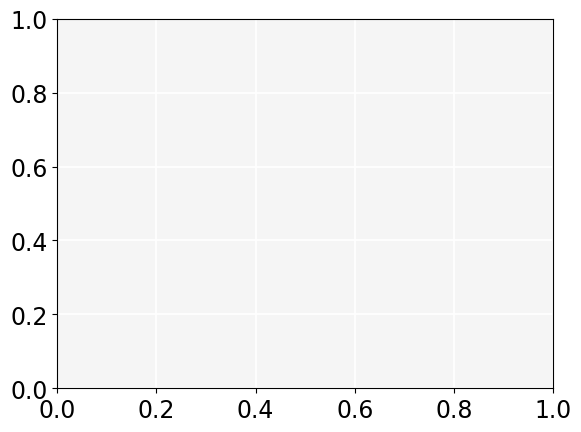

In [44]:
# Record once every 100 iterations, and 10 workers need to communicate in each iteration
original_num = 1000
k=1
print("original communication number:", original_num)

TASGS_data = pd.read_csv("./result/"+"TASGS-full-iter-fa.csv")
SASG_data = pd.read_csv("./result/"+"SASG-full-iter-fa.csv")
LASG_data = pd.read_csv("./result/"+"LASG-full-iter-fa.csv")
sparse_data = pd.read_csv("./result/"+"Sparse-full-iter-fa.csv")
sgd_data = pd.read_csv("./result/"+"SGD-full-iter-fa.csv")

TASGS_skip = TASGS_data['Skip'].values.tolist()
SASG_skip = SASG_data['Skip'].values.tolist()
LASG_skip = LASG_data['Skip'].values.tolist()

comm_round_TASGS = []
comm_round_SASG = []
comm_round_LASG = []
comm_round_sparse = []
comm_round_dis = []

comm_bit_TASGS = []
comm_bit_SASG = []
comm_bit_LASG = []
comm_bit_sparse = []
comm_bit_dis = []

Eopch_TASGS = []
Eopch_SASG = []
Eopch_LASG = []
Eopch_sparse = []
Eopch_dis = []



comm_num_TASGS, comm_num_SASG, comm_num_LASG, comm_num_sparse, comm_num_dis = 0, 0, 0, 0 ,0
Eopch_n_TASGS,Eopch_n_SASG,Eopch_n_LASG,Eopch_n_sparse,Eopch_n_dis=0,0,0,0,0
for i in range(len(TASGS_skip)):
    
    comm_num_TASGS += original_num
    a= comm_num_TASGS - TASGS_skip[i]
#     print("总轮次",a)
    comm_round_TASGS.append(a)
    
    
for i in range(len(SASG_skip)):
    comm_num_SASG += original_num
    b=comm_num_SASG - SASG_skip[i]

    comm_round_SASG.append(b)

for i in range(len(LASG_skip)):
    comm_num_LASG += original_num
    comm_num_sparse += original_num
    comm_num_dis += original_num
    
    c=comm_num_LASG - LASG_skip[i]


    comm_round_LASG.append(c)
    comm_round_sparse.append(comm_num_sparse)
comm_round_dis.append(comm_num_dis)


for k in range(20):
    Eopch_n_TASGS += k
    Eopch_n_SASG += k
    Eopch_n_LASG += k
    Eopch_n_sparse += k
    Eopch_n_dis += k
    
    Eopch_TASGS.append(Eopch_n_TASGS)
    Eopch_SASG.append(Eopch_n_SASG)
    Eopch_LASG.append(Eopch_n_LASG)
    Eopch_sparse.append(Eopch_n_sparse)
    Eopch_dis.append(Eopch_n_dis)
    
font1 = {'weight': 'normal', 'size': 17}
font2 = {'weight': 'normal', 'size': 20}

plt.figure()
plt.rc('font', size=17)
plt.subplot(facecolor="whitesmoke")
plt.grid(axis="x", color='w', linestyle='-', which='major', linewidth=1.2)
plt.grid(axis="y", color='w', linestyle='-', which='major', linewidth=1.2)
plt.plot(comm_round_dis, sgd_data['test-acc'].values.tolist(), 'black', label='SGD', linewidth=2.5, linestyle='-')
# plt.plot(comm_round_sparse, sparse_data['test-acc'].values.tolist(), 'b', label='Sparse', linewidth=2.5, linestyle='-')
# plt.plot(comm_round_LASG, LASG_data['test-acc'].values.tolist(), 'g', label='LASG', linewidth=2.5)
# plt.plot(comm_round_SASG, SASG_data['test-acc'].values.tolist(), 'r', label='SASG', linewidth=2.5)
# plt.plot(comm_round_TASGS, TASGS_data['test-acc'].values.tolist(), 'c', label='GSASG', linewidth=2.5)
ax = plt.gca()
xmajorLocator = MultipleLocator(40000)  # major
ax.xaxis.set_major_locator(xmajorLocator)
xminorLocator = MultipleLocator(20000)  # minor
ax.xaxis.set_minor_locator(xminorLocator)
ax.ticklabel_format(axis='x', style='scientific', scilimits=(0, 0))
plt.xlabel('Communication Round', font2)
plt.ylim(75, 90)
ymajorLocator = MultipleLocator(2)  # major
ax.yaxis.set_major_locator(ymajorLocator)
yminorLocator = MultipleLocator(1)  # minor
ax.yaxis.set_minor_locator(yminorLocator)
plt.ylabel('Test Accuracy', font2)



legend = plt.legend(prop=font1)
plt.subplots_adjust(left=0.13, right=0.95, bottom=0.15, top=0.95)

plt.savefig("./result/"+"test_full.png", dpi=600)
plt.show()

plt.figure()
plt.rc('font', size=17)
plt.subplot(facecolor="whitesmoke")
plt.grid(axis="x", color='w', linestyle='-', which='major', linewidth=1.2)
plt.grid(axis="y", color='w', linestyle='-', which='major', linewidth=1.2)
plt.plot(comm_round_dis, sgd_data['Loss'].values.tolist(), 'black', label='SGD', linewidth=2.5, linestyle='-')
# plt.plot(comm_round_sparse, sparse_data['Loss'].values.tolist(), 'b', label='Sparse', linewidth=2.5, linestyle='-.')
# plt.plot(comm_round_LASG, LASG_data['Loss'].values.tolist(), 'g', label='LASG', linewidth=2.5)
# plt.plot(comm_round_SASG, SASG_data['Loss'].values.tolist(), 'r', label='SASG', linewidth=2.5)
# plt.plot(comm_round_TASGS, TASGS_data['Loss'].values.tolist(), 'c', label='GSASG', linewidth=2.5)
ax = plt.gca()
xmajorLocator = MultipleLocator(40000)  # major
ax.xaxis.set_major_locator(xmajorLocator)
xminorLocator = MultipleLocator(20000)  # minor
ax.xaxis.set_minor_locator(xminorLocator)
ax.ticklabel_format(axis='x', style='scientific', scilimits=(0, 0))
# ax.ticklabel_format(axis='y', style='plain', scilimits=(0, 0))
plt.xlabel('Communication Round', font2)

plt.yscale('log')
plt.ylabel('Loss', font2)
# plt.ylim(0, 2)
# ax.set_yticks((0.1, 1,)
# ax.set_yticklabels([ '$10^{0}$', '$ 10^{-1}$'], fontsize=17)
legend = plt.legend(prop=font1)
plt.subplots_adjust(left=0.16, right=0.95, bottom=0.15, top=0.95)
plt.savefig("./result/"+"loss_full.png", dpi=600)
plt.show()

original communication number: 1000


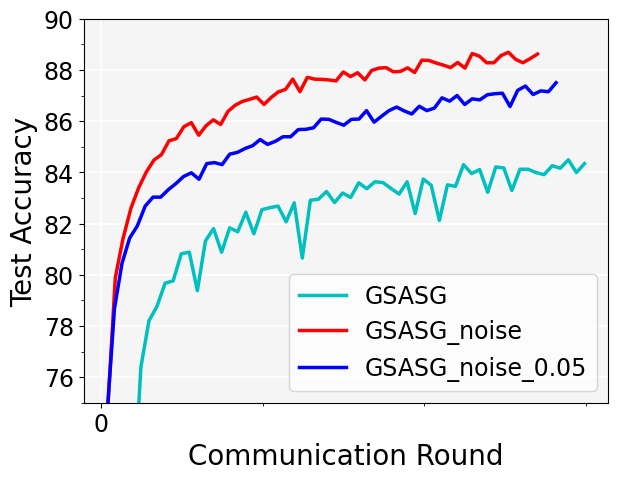

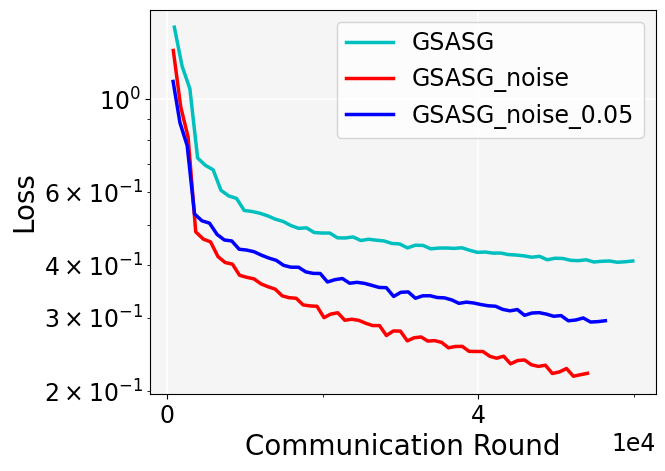

In [3]:
# Record once every 100 iterations, and 10 workers need to communicate in each iteration
original_num = 1000
k=1
print("original communication number:", original_num)

TASGS_data = pd.read_csv("./result/"+"TASGS-full-iter-fa.csv")
TASGS_noise_data = pd.read_csv("./result/"+"TASGS-full-iter-fa-nosie.csv")
TASGS_noise1_data = pd.read_csv("./result/"+"TASGS-full-iter-fa-nosie1.csv")


TASGS_skip = TASGS_data['Skip'].values.tolist()
TASGS_noise_skip = TASGS_noise_data['Skip'].values.tolist()
TASGS_noise1_skip = TASGS_noise1_data['Skip'].values.tolist()



comm_round_TASGS = []
comm_round_TASGS_noise = []
comm_round_TASGS_noise1 = []


comm_bit_TASGS = []
comm_bit_TASGS_noise = []
comm_bit_TASGS_noise1 = []


Eopch_TASGS = []
Eopch_TASGS_noise = []
Eopch_TASGS_noise1 = []





comm_num_TASGS, comm_num_TASGS_noise,comm_num_TASGS_noise1 = 0, 0, 0
Eopch_n_TASGS,Eopch_n_TASGS_noise,Eopch_n_TASGS_noise1=0,0,0
for i in range(len(TASGS_skip)):
    
    comm_num_TASGS += original_num
    a= comm_num_TASGS - TASGS_skip[i]
#     print("总轮次",a)
    comm_round_TASGS.append(a)
    
    
for i in range(len(TASGS_noise_skip)):
    comm_num_TASGS_noise += original_num
    b=comm_num_TASGS_noise - TASGS_noise_skip[i]

    comm_round_TASGS_noise.append(b)
    
    
for i in range(len(TASGS_noise1_skip)):
    comm_num_TASGS_noise1 += original_num
    c=comm_num_TASGS_noise1 - TASGS_noise1_skip[i]

    comm_round_TASGS_noise1.append(c)

# for i in range(len(LASG_skip)):
#     comm_num_LASG += original_num
#     comm_num_sparse += original_num
#     comm_num_dis += original_num
    
#     c=comm_num_LASG - LASG_skip[i]


#     comm_round_LASG.append(c)
#     comm_round_sparse.append(comm_num_sparse)
#     comm_round_dis.append(comm_num_dis)


# for k in range(20):
#     Eopch_n_TASGS += k
#     Eopch_n_SASG += k
#     Eopch_n_LASG += k
#     Eopch_n_sparse += k
#     Eopch_n_dis += k
    
#     Eopch_TASGS.append(Eopch_n_TASGS)
#     Eopch_SASG.append(Eopch_n_SASG)
#     Eopch_LASG.append(Eopch_n_LASG)
#     Eopch_sparse.append(Eopch_n_sparse)
#     Eopch_dis.append(Eopch_n_dis)
    
font1 = {'weight': 'normal', 'size': 17}
font2 = {'weight': 'normal', 'size': 20}

plt.figure()
plt.rc('font', size=17)
plt.subplot(facecolor="whitesmoke")
plt.grid(axis="x", color='w', linestyle='-', which='major', linewidth=1.2)
plt.grid(axis="y", color='w', linestyle='-', which='major', linewidth=1.2)
plt.plot(comm_round_TASGS, TASGS_data['test-acc'].values.tolist(), 'c', label='GSASG', linewidth=2.5, linestyle='-')
plt.plot(comm_round_TASGS_noise, TASGS_noise_data['test-acc'].values.tolist(), 'r', label='GSASG_noise', linewidth=2.5, linestyle='-')
plt.plot(comm_round_TASGS_noise1, TASGS_noise1_data['test-acc'].values.tolist(), 'b', label='GSASG_noise_0.05', linewidth=2.5, linestyle='-')

ax = plt.gca()

xmajorLocator = MultipleLocator(80000)  # m
ax.xaxis.set_major_locator(xmajorLocator)
xminorLocator = MultipleLocator(20000)  # minor
ax.xaxis.set_minor_locator(xminorLocator)
ax.ticklabel_format(axis='x', style='scientific', scilimits=(0, 0))
plt.xlabel('Communication Round', font2)
plt.ylim(75, 90)
ymajorLocator = MultipleLocator(2)  # major
ax.yaxis.set_major_locator(ymajorLocator)
yminorLocator = MultipleLocator(1)  # minor
ax.yaxis.set_minor_locator(yminorLocator)
plt.ylabel('Test Accuracy', font2)



legend = plt.legend(prop=font1)
plt.subplots_adjust(left=0.13, right=0.95, bottom=0.15, top=0.95)

plt.savefig("./result/"+"test_full.png", dpi=600)
plt.show()

plt.figure()
plt.rc('font', size=17)
plt.subplot(facecolor="whitesmoke")
plt.grid(axis="x", color='w', linestyle='-', which='major', linewidth=1.2)
plt.grid(axis="y", color='w', linestyle='-', which='major', linewidth=1.2)

plt.plot(comm_round_TASGS, TASGS_data['Loss'].values.tolist(), 'c', label='GSASG', linewidth=2.5)
plt.plot(comm_round_TASGS_noise, TASGS_noise_data['Loss'].values.tolist(), 'r', label='GSASG_noise', linewidth=2.5)
plt.plot(comm_round_TASGS_noise1, TASGS_noise1_data['Loss'].values.tolist(), 'b', label='GSASG_noise_0.05', linewidth=2.5)

ax = plt.gca()
xmajorLocator = MultipleLocator(40000)  # major
ax.xaxis.set_major_locator(xmajorLocator)
xminorLocator = MultipleLocator(20000)  # minor
ax.xaxis.set_minor_locator(xminorLocator)
ax.ticklabel_format(axis='x', style='scientific', scilimits=(0, 0))
# ax.ticklabel_format(axis='y', style='plain', scilimits=(0, 0))
plt.xlabel('Communication Round', font2)

plt.yscale('log')
plt.ylabel('Loss', font2)
# plt.ylim(0, 2)
# ax.set_yticks((0.1, 1,)
# ax.set_yticklabels([ '$10^{0}$', '$ 10^{-1}$'], fontsize=17)
legend = plt.legend(prop=font1)
plt.subplots_adjust(left=0.16, right=0.95, bottom=0.15, top=0.95)
plt.savefig("./result/"+"loss_full.png", dpi=600)
plt.show()